In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import modeling

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [2]:
# Plot defaults
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

In [3]:
# Read in the data - Global Average Absolute Sea Level Change
df = pd.read_csv('sea_levels_2015.csv',index_col=0)

In [4]:
df.tail()

,GMSL,GMSL uncertainty
Time,,
2013-08-15,71.6,8.8
2013-09-15,68.8,8.8
2013-10-15,66.4,8.9
2013-11-15,59.7,9.0
2013-12-15,58.5,9.0


In [5]:
df.describe

<bound method NDFrame.describe of              GMSL  GMSL uncertainty
Time                               
1880-01-15 -183.0              24.2
1880-02-15 -171.1              24.2
1880-03-15 -164.3              24.2
1880-04-15 -158.2              24.2
1880-05-15 -158.7              24.2
...           ...               ...
2013-08-15   71.6               8.8
2013-09-15   68.8               8.8
2013-10-15   66.4               8.9
2013-11-15   59.7               9.0
2013-12-15   58.5               9.0

[1608 rows x 2 columns]>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1608 entries, 1880-01-15 to 2013-12-15
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GMSL              1608 non-null   float64
 1   GMSL uncertainty  1608 non-null   float64
dtypes: float64(2)
memory usage: 37.7+ KB


In [7]:
df.isna().sum()

GMSL                0
GMSL uncertainty    0
dtype: int64

In [8]:
df.dtypes

GMSL                float64
GMSL uncertainty    float64
dtype: object

In [9]:
df.index.min(), df.index.max()

('1880-01-15', '2013-12-15')

In [10]:
# Drop unnecessary columns
df = df.drop(['GMSL uncertainty'], axis=1)

Sea levels show a steadily upward trend since 1880.

In [11]:
# convert mm to inches
df['GMSL'] = df['GMSL'] / 25.4

In [12]:
# 'Zero' out the plot on the y-axis for readability.
df['GMSL'] = df['GMSL'] + 7.204724

(array([ 44., 210., 340., 193., 145., 207., 201., 128.,  82.,  58.]),
 array([-0.05905553,  0.99173187,  2.04251928,  3.09330668,  4.14409408,
         5.19488148,  6.24566888,  7.29645628,  8.34724369,  9.39803109,
        10.44881849]),
 <BarContainer object of 10 artists>)

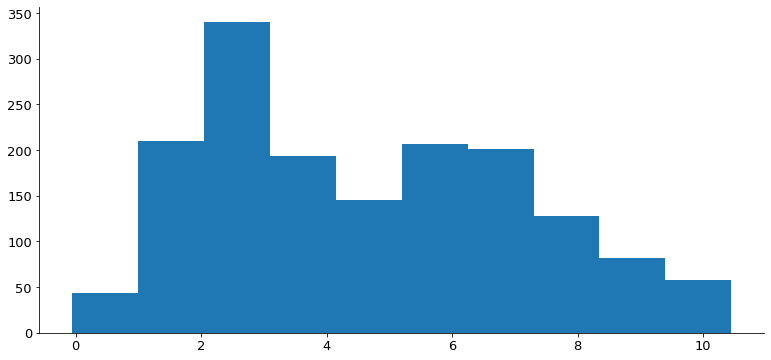

In [13]:
plt.hist(df['GMSL'])

<AxesSubplot:xlabel='Time'>

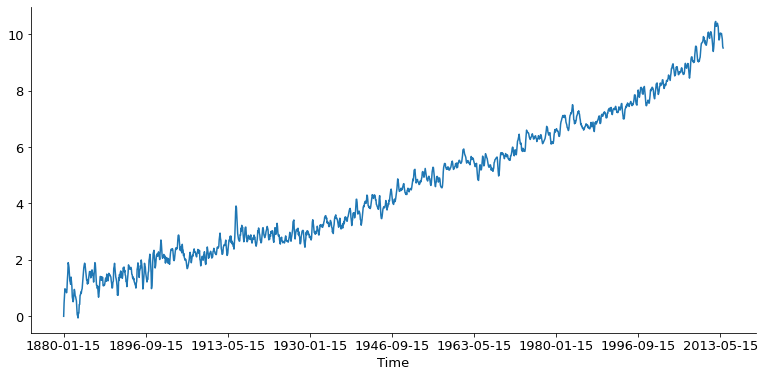

In [14]:
df['GMSL'].plot()

In [15]:
df

,GMSL
Time,
1880-01-15,-4.094488e-07
1880-02-15,4.685035e-01
1880-03-15,7.362201e-01
1880-04-15,9.763775e-01
1880-05-15,9.566925e-01
...,...
2013-08-15,1.002362e+01
2013-09-15,9.913385e+00
2013-10-15,9.818897e+00


In [16]:
df.index = pd.to_datetime(df.index)


In [17]:
# set train size to be 50% of total 
train_size = int(len(df) * 0.5)
train_size

804

In [18]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size

482

In [19]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

322

In [20]:
# validate will go from 804 to 804+482
validate_end_index = train_size + validate_size
validate_end_index

1286

In [21]:
# train will go from 0 to 803
train = df[:train_size]
# validate will go from 804 to 1285
validate = df[train_size:validate_end_index]
# test will include 1286 to the end
test = df[validate_end_index:]

In [22]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [23]:

print(df.head(1) == train.head(1))

            GMSL
Time            
1880-01-15  True


Is the last row of train the day before the first row of validate? And the same for validate to test?

In [24]:
pd.concat([train.tail(1), validate.head(1)])

,GMSL
Time,
1946-12-15,3.988189
1947-01-15,3.964567


In [25]:
pd.concat([validate.tail(1), test.head(1)])

,GMSL
Time,
1987-02-15,6.870078
1987-03-15,6.779527



Is the last row of test the same as the last row of our original dataframe?

In [26]:
pd.concat([test.tail(1), df.tail(1)])

,GMSL
Time,
2013-12-15,9.507874
2013-12-15,9.507874



Plot the data, viewing where the data is split into train and test.

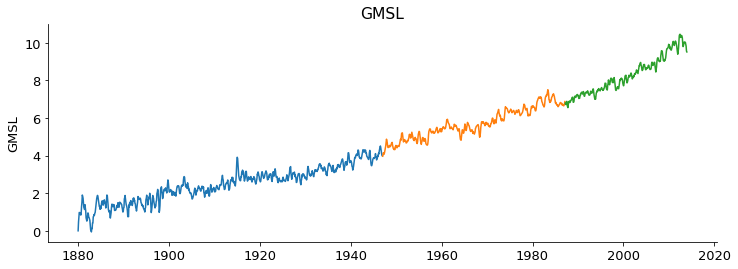

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train['GMSL'])
plt.plot(validate['GMSL'])
plt.plot(test['GMSL'])
plt.ylabel('GMSL')
plt.title('GMSL')
plt.show()

### Last observed value
The simplest method for forecasting is to predict all future values to be the last observed value.

Make Predictions



In [28]:
# take the last recorded train sea level and assign to variable
latest_level = round(train['GMSL'][-1:][0], 2)
latest_level

3.99

In [29]:
yhat_df = pd.DataFrame({'GMSL': [latest_level]}, 
                      index = validate.index)

yhat_df.head()

,GMSL
Time,
1947-01-15,3.99
1947-02-15,3.99
1947-03-15,3.99
1947-04-15,3.99
1947-05-15,3.99


#### Plot Actual vs. Predicted Values

Plot actual and predicted values

GMSL -- RMSE: 2


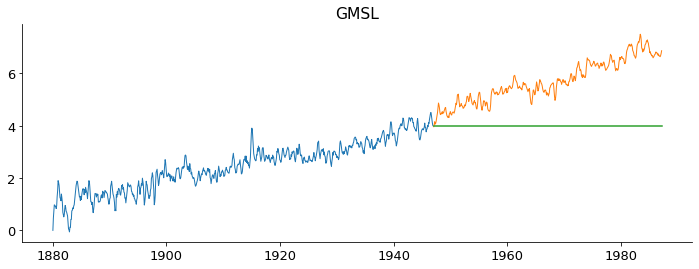

In [30]:
modeling.plot_and_eval(train, validate, yhat_df, 'GMSL')

Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.

In [31]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [32]:
eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'last_observed_value', 'GMSL')

eval_df

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0


#### Simple Average
Take the simple average of historical values and use that value to predict future values.



In [33]:
# compute simple average
ave_level = round(train['GMSL'].mean(), 2)
ave_level

2.48

In [34]:
yhat_df = pd.DataFrame({'GMSL': [ave_level]},
                          index=validate.index)

In [35]:
yhat_df.head()

,GMSL
Time,
1947-01-15,2.48
1947-02-15,2.48
1947-03-15,2.48
1947-04-15,2.48
1947-05-15,2.48


#### Plot Actual vs. Predicted Values

Plot and evaluate the performance of the time series model using Simple Average

GMSL -- RMSE: 3


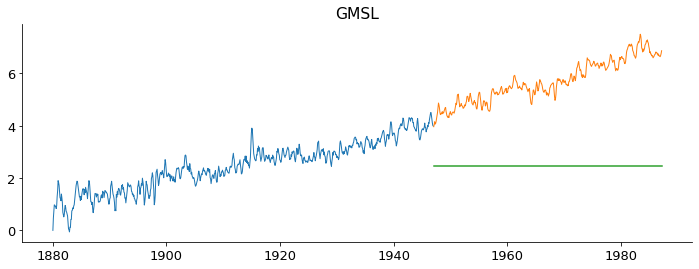

In [36]:
modeling.plot_and_eval(train, validate, yhat_df,'GMSL')

In [37]:
eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'simple_average', 'GMSL')
eval_df

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0
1,simple_average,GMSL,3.0


#### Moving Average
In this example, a 30-day moving average will be used to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [38]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_level = round(train['GMSL'].rolling(period).mean()[-1], 2)
print(rolling_level)

3.97


In [39]:
yhat_df = pd.DataFrame({'GMSL': [rolling_level]},
                          index=validate.index)

In [40]:

yhat_df.head()

,GMSL
Time,
1947-01-15,3.97
1947-02-15,3.97
1947-03-15,3.97
1947-04-15,3.97
1947-05-15,3.97


#### Plot Actual vs. Predicted Values

Plot and evaluate the performance of the time series model using Moving Average

GMSL -- RMSE: 2


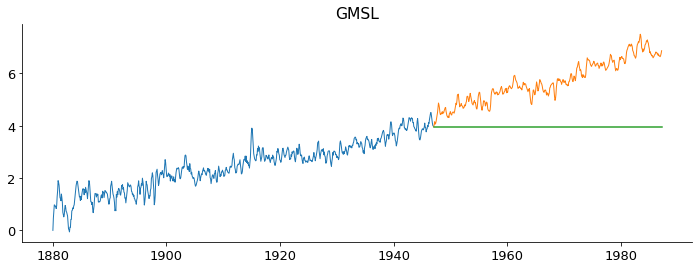

In [41]:
modeling.plot_and_eval(train, validate, yhat_df, 'GMSL')

In [42]:
eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'rolling_average', 'GMSL')
eval_df

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0
1,simple_average,GMSL,3.0
2,rolling_average,GMSL,2.0


Let's try out several other values for periods:

In [43]:
periods = [4, 12, 26, 52, 104]

for period in periods: 
    dollars = round(train['GMSL'].rolling(period).mean()[-1], 2)
    yhat_df = pd.DataFrame({'GMSL': [rolling_level]},
                          index=validate.index)
    model_type = str(period) + 'd_moving_avg'
    eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'rolling_average', 'GMSL')

In [44]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0
1,simple_average,GMSL,3.0
2,rolling_average,GMSL,2.0
3,rolling_average,GMSL,2.0
4,rolling_average,GMSL,2.0
5,rolling_average,GMSL,2.0
6,rolling_average,GMSL,2.0
7,rolling_average,GMSL,2.0


Which is best so far?

In [45]:
min_items_rmse = eval_df[eval_df.target_var == 'GMSL']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0
2,rolling_average,GMSL,2.0
3,rolling_average,GMSL,2.0
4,rolling_average,GMSL,2.0
5,rolling_average,GMSL,2.0
6,rolling_average,GMSL,2.0
7,rolling_average,GMSL,2.0


#### Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).

$\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.

$\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.
Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

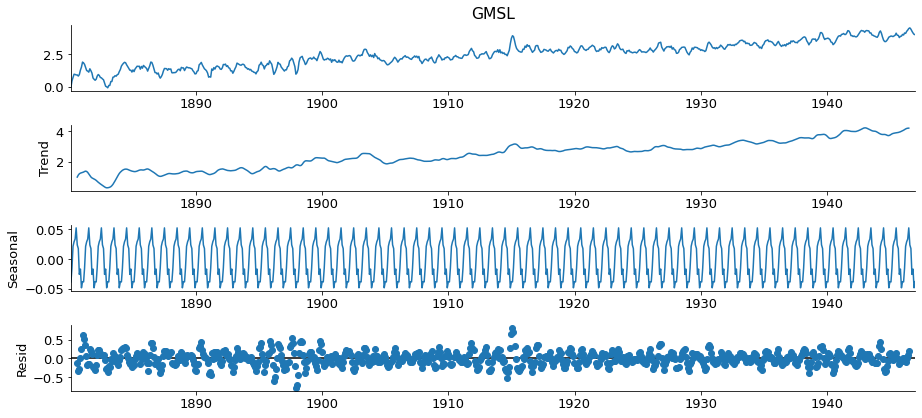

In [46]:
sm.tsa.seasonal_decompose(train['GMSL'].resample('M').mean()).plot()
plt.show()

#### Basic Holt's Linear Trend
Make Predictions

Create the Holt object, fit the model, and make predictions.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.

fit:

- smoothing_level ($\alpha$): value between (0,1)

- smoothing_slope ($\beta$): value between (0,1)

- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

In [47]:
# Resample the train and validate, populate yhat_df
train = train.resample('M')[['GMSL']].mean()
validate = validate.resample('M')[['GMSL']].mean()
yhat_df = pd.DataFrame({'GMSL': [ave_level]},
                          index=validate.index)

In [48]:
model = Holt(train['GMSL'], exponential = False)
model = model.fit(smoothing_level = .1, 
                    smoothing_slope = .1, 
                    optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                            end = validate.index[-1])

yhat_df['GMSL'] = yhat_items

In [49]:
yhat_df

,GMSL
Time,
1947-01-31,4.211272
1947-02-28,4.232302
1947-03-31,4.253332
1947-04-30,4.274362
1947-05-31,4.295392
...,...
1986-10-31,14.242548
1986-11-30,14.263578
1986-12-31,14.284608


Plot Actual vs. Predicted Values

GMSL -- RMSE: 4


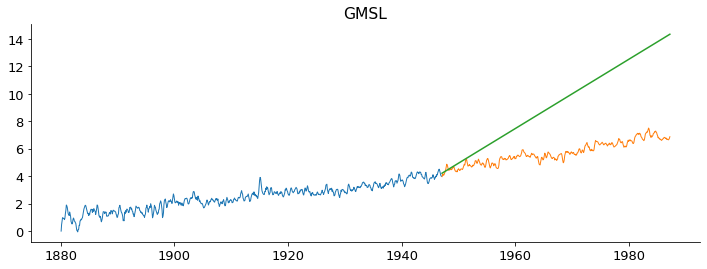

In [50]:
modeling.plot_and_eval(train, validate, yhat_df, 'GMSL')

In [51]:
eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'holts_optimized', 'GMSL')
eval_df

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0
1,simple_average,GMSL,3.0
2,rolling_average,GMSL,2.0
3,rolling_average,GMSL,2.0
4,rolling_average,GMSL,2.0
5,rolling_average,GMSL,2.0
6,rolling_average,GMSL,2.0
7,rolling_average,GMSL,2.0
8,holts_optimized,GMSL,4.0


Let's do another model, changing some hyperparameters.

In [52]:
model = Holt(train['GMSL'], exponential=False)
model = model.fit(smoothing_level=0.1,
                      smoothing_slope=0.1,
                      optimized=False)
yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
yhat_df['GMSL'] = round(yhat_items, 2)

GMSL -- RMSE: 4


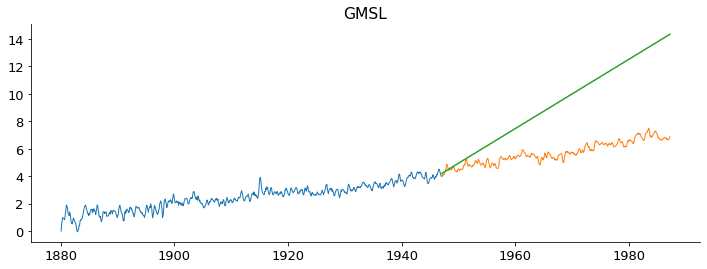

In [53]:
modeling.plot_and_eval(train, validate, yhat_df, 'GMSL')

In [54]:
eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'holts.1', 'GMSL')
eval_df

,model_type,target_var,rmse
0,last_observed_value,GMSL,2.0
1,simple_average,GMSL,3.0
2,rolling_average,GMSL,2.0
3,rolling_average,GMSL,2.0
4,rolling_average,GMSL,2.0
5,rolling_average,GMSL,2.0
6,rolling_average,GMSL,2.0
7,rolling_average,GMSL,2.0
8,holts_optimized,GMSL,4.0
9,holts.1,GMSL,4.0


## Predict Based on Previous Cycle
Take all the 2012 data points, compute the monthly delta, year-over-year, average that delta over all the months, and adding that average to the previous year's value on a month will give you the forecast for that month.

In the below example:

Compute the monthly average year over year differences from 2009 through 2011
Add that average delta to the values during 2011.
Set the index in your yhat dataframe to represent the dates those predictions are make for.


Re-split data

In [55]:
train = df[:'2011']
validate = df['2012']
test = df['2013']


In [56]:
print(train.shape)
print(validate.shape)
print(test.shape)


(1584, 1)
(12, 1)
(12, 1)


In [57]:

yhat_df = train['2011'] + train.diff(30).mean()


In [58]:
train.loc['2011'].head()

,GMSL
Time,
2011-01-15,9.976378
2011-02-15,9.901574
2011-03-15,9.850393
2011-04-15,9.984252
2011-05-15,10.062992


In [59]:

yhat_df.head()

,GMSL
Time,
2011-01-15,10.146231
2011-02-15,10.071428
2011-03-15,10.020247
2011-04-15,10.154105
2011-05-15,10.232845


In [60]:
# let's peek into the prediction we will make for 1/15/2012
# by comparing the predicted value 
# (2011 value + year-over-year average difference)
# to the actual 1/15/2012 value
pd.concat([yhat_df.head(1), validate.head(1)])

,GMSL
Time,
2011-01-15,10.146231
2012-01-15,9.507874


In [61]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [62]:
yhat_df.head()

,GMSL
Time,
2012-01-15,10.146231
2012-02-15,10.071428
2012-03-15,10.020247
2012-04-15,10.154105
2012-05-15,10.232845


GMSL -- RMSE: 0


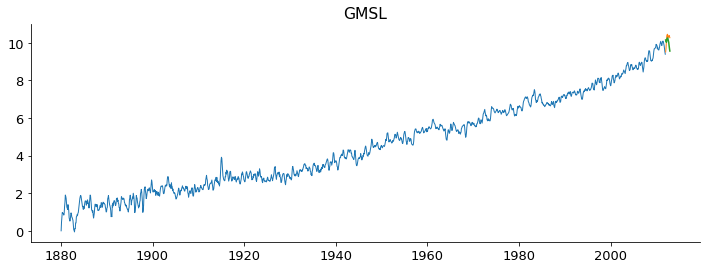

In [63]:
modeling.plot_and_eval(train, validate, yhat_df, 'GMSL')
eval_df = modeling.append_eval_df(validate, yhat_df, eval_df, 'previous_year', 'GMSL')

## Conclusion
Which model did the best?

In [64]:
min_items_rmse = eval_df[eval_df.target_var == 'GMSL']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
10,previous_year,GMSL,0.0


Let's test it out on our out-of-sample data

We will be using train + validate to predict test.

In [65]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [66]:
rmse_GMSL = sqrt(mean_squared_error(test['GMSL'], 
                                       yhat_df['GMSL']))


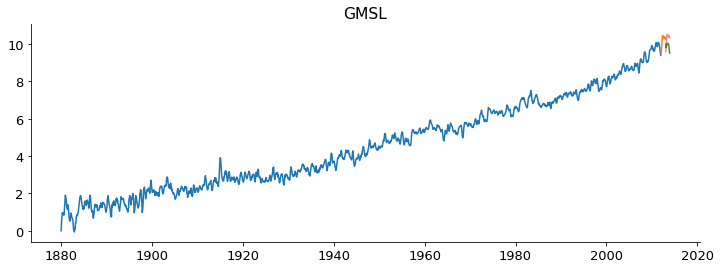

In [67]:
plt.figure(figsize=(12,4))
plt.plot(train['GMSL'], label='train')
plt.plot(validate['GMSL'], label='validate')
plt.plot(test['GMSL'], label='test')
plt.plot(yhat_df['GMSL'], alpha=.5)
plt.title('GMSL')
plt.show()


In [68]:
# to predict 2014

yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')


In [69]:
yhat_df.head()

,GMSL
Time,
2014-01-15 05:49:12,10.048243
2014-02-15 05:49:12,9.859267
2014-03-15 05:49:12,9.910448
2014-04-15 05:49:12,10.020684
2014-05-15 05:49:12,10.107298


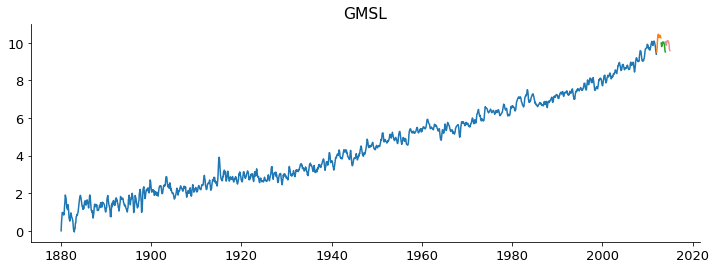

In [70]:
plt.figure(figsize=(12,4))
plt.plot(train['GMSL'], label='train')
plt.plot(validate['GMSL'], label='validate')
plt.plot(test['GMSL'], label='test')
plt.plot(yhat_df['GMSL'], alpha=.5)
plt.title('GMSL')
plt.show()